# GoogleNet/Inception v3 (Transfer Learning)

In [26]:
import torch
import torchvision.models as models
from torch import nn, optim
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
from torchsummary import summary
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from ptflops import get_model_complexity_info
from PIL import Image
import time
import matplotlib.pyplot as plt
import seaborn as sns

In [19]:
# Device configuration (Select CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\n Device : {device}")


 Device : cuda


### Load and prepare the data

In [20]:
# Transformations for the dataset
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Convert grayscale-like images to 3 channels
    transforms.Resize((342, 342)),               # Resize to slightly larger than 299x299
    transforms.CenterCrop(299),                  # Crop to 299x299 as required by Inception v3
    transforms.ToTensor(),                       # Convert images to tensors
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Normalize
])

# Custom dataset class to handle CSV and image folder
class SARImageDataset(torch.utils.data.Dataset):
    def __init__(self, csv_file, image_folder, transform=None):
        self.data = pd.read_csv(csv_file)
        self.image_folder = image_folder
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = f"{self.image_folder}/{self.data.iloc[idx, 0]}.png"
        label = self.data.iloc[idx, 1]
        image = Image.open(img_name)

        if self.transform:
            image = self.transform(image)

        return image, label

# Load full training dataset
train_val_dataset = SARImageDataset(csv_file="data/train.csv", image_folder="data/images_train", transform=transform)
test_dataset = SARImageDataset(csv_file="data/test.csv", image_folder="data/images_test", transform=transform)

# Split into training and validation datasets
train_size = int(0.8 * len(train_val_dataset))  # 80% for training
val_size = len(train_val_dataset) - train_size  # 20% for validation
train_dataset, val_dataset = random_split(train_val_dataset, [train_size, val_size])

# DataLoaders for batching
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

### Load pre-trained ResNet50 model and modify it

In [21]:
# Load pre-trained GoogleNet
# model = models.googlenet(pretrained=True) # Loading Inception v1 by default. 
model = models.inception_v3(pretrained=True) # Select specific model

# Modify the final fully connected layer for binary classification
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)  # Binary classification: Internal waves (1) or No waves (0)
model = model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Print summary
summary(model, input_size=(3, 299, 299))

C:\Users\ishar\.virtualenvs\ML_env\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\ishar\.virtualenvs\ML_env\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 149, 149]             864
       BatchNorm2d-2         [-1, 32, 149, 149]              64
       BasicConv2d-3         [-1, 32, 149, 149]               0
            Conv2d-4         [-1, 32, 147, 147]           9,216
       BatchNorm2d-5         [-1, 32, 147, 147]              64
       BasicConv2d-6         [-1, 32, 147, 147]               0
            Conv2d-7         [-1, 64, 147, 147]          18,432
       BatchNorm2d-8         [-1, 64, 147, 147]             128
       BasicConv2d-9         [-1, 64, 147, 147]               0
        MaxPool2d-10           [-1, 64, 73, 73]               0
           Conv2d-11           [-1, 80, 73, 73]           5,120
      BatchNorm2d-12           [-1, 80, 73, 73]             160
      BasicConv2d-13           [-1, 80, 73, 73]               0
           Conv2d-14          [-1, 192,

### Train the model

In [23]:
# Initialize a df to log training/validation metrics
log_df = pd.DataFrame(columns=["Epoch", "Train Loss", "Validation Loss", "Validation Accuracy"])

# Record the start time
start_time = time.time()

# Training loop
num_epochs = 50
best_val_loss = float('inf')  # Initialize best validation loss for saving model

for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)

        # Handle InceptionOutputs
        if isinstance(outputs, tuple):  # Outputs: (logits, aux_logits)
            logits, aux_logits = outputs
        else:
            logits = outputs

        # Compute the loss using main logits
        loss = criterion(logits, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            # Handle InceptionOutputs during validation
            if isinstance(outputs, tuple):  # Outputs: (logits, aux_logits)
                logits, aux_logits = outputs
            else:
                logits = outputs

            # Compute validation loss using main logits
            loss = criterion(logits, labels)
            val_loss += loss.item()

            _, predicted = torch.max(logits, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_accuracy = val_correct / val_total * 100

    # Calculate FLOPs after each epoch
    with torch.no_grad():
        flops, _ = get_model_complexity_info(model, (3, 224, 224), as_strings=False, print_per_layer_stat=False)

    # Log metrics into the DataFrame
    new_row = {
        "Epoch": epoch + 1,
        "Train_Loss": train_loss / len(train_loader),
        "Validation_Loss": val_loss / len(val_loader),
        "Validation_Accuracy": val_accuracy,
        "FLOPs": flops
    }
    log_df = pd.concat([log_df, pd.DataFrame([new_row])], ignore_index=True)

    # Print metrics for this epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss / len(train_loader):.4f}, "
          f"Val Loss: {val_loss / len(val_loader):.4f}, Val Accuracy: {val_accuracy:.2f}%, "
          f"GFLOPs: {(flops / 1e9 ):.2f}")

    # Save the best model based on validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "model_outputs_data/best_googlenet_inception_v3_model.pth")

# Calculate the total training time in seconds
print(f"\nTotal Training Time: {(time.time() - start_time):.2f} seconds")

# Save the DataFrame to a CSV file for later use
log_df.to_csv("model_outputs_data/model_evaluation_logs/training_google_inception_v3_net_logs.csv", index=False)

Epoch [1/50], Train Loss: 0.3297, Val Loss: 0.7538, Val Accuracy: 80.76%, GFLOPs: 2.85
Epoch [2/50], Train Loss: 0.3208, Val Loss: 0.4453, Val Accuracy: 83.85%, GFLOPs: 2.85
Epoch [3/50], Train Loss: 0.2349, Val Loss: 0.4694, Val Accuracy: 84.88%, GFLOPs: 2.85
Epoch [4/50], Train Loss: 0.2417, Val Loss: 0.4328, Val Accuracy: 83.85%, GFLOPs: 2.85
Epoch [5/50], Train Loss: 0.2084, Val Loss: 0.3297, Val Accuracy: 88.11%, GFLOPs: 2.85
Epoch [6/50], Train Loss: 0.1712, Val Loss: 1.4360, Val Accuracy: 70.63%, GFLOPs: 2.85
Epoch [7/50], Train Loss: 0.1358, Val Loss: 0.2879, Val Accuracy: 89.28%, GFLOPs: 2.85
Epoch [8/50], Train Loss: 0.1605, Val Loss: 0.3606, Val Accuracy: 86.20%, GFLOPs: 2.85
Epoch [9/50], Train Loss: 0.0925, Val Loss: 0.3796, Val Accuracy: 88.84%, GFLOPs: 2.85
Epoch [10/50], Train Loss: 0.1148, Val Loss: 0.8544, Val Accuracy: 71.95%, GFLOPs: 2.85
Epoch [11/50], Train Loss: 0.0861, Val Loss: 0.3335, Val Accuracy: 89.72%, GFLOPs: 2.85
Epoch [12/50], Train Loss: 0.1129, Val Lo

### Prediction and Model evaluation

In [29]:
# Test the model
model.eval()
# model.load_state_dict(torch.load("model_outputs_data/best_googlenet_inception_v3_model.pth"))  # Load the best model

all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

# Compute Evaluation Metrics
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='binary')
recall = recall_score(all_labels, all_preds, average='binary')
f1 = f1_score(all_labels, all_preds, average='binary')

print(f"\nTest Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

# Classification Report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=["No Internal Waves", "Internal Waves"]))

# Confusion Matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(all_labels, all_preds)
print(cm)


Test Accuracy: 89.65%
Precision: 0.95
Recall: 0.84
F1-Score: 0.89

Classification Report:
                   precision    recall  f1-score   support

No Internal Waves       0.85      0.96      0.90       719
   Internal Waves       0.95      0.84      0.89       740

         accuracy                           0.90      1459
        macro avg       0.90      0.90      0.90      1459
     weighted avg       0.90      0.90      0.90      1459


Confusion Matrix:
[[689  30]
 [121 619]]


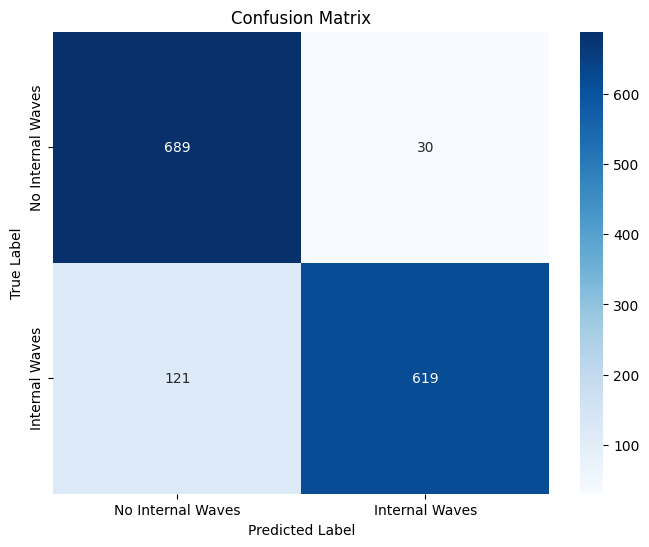

In [30]:
# Plot confusion matrix
classes = ["No Internal Waves", "Internal Waves"]
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()